In [3]:
import os

gpu_id = "1" 
os.environ['CUDA_VISIBLE_DEVICES'] = f"{gpu_id}"  # MUST before `import torch` in this files and any imported packages
from pathlib import Path
import warnings
import numpy as np
import sys
from keras import backend as K
from keras.models import Model
from tqdm import tqdm

warnings.filterwarnings("ignore")  # 忽略keras带来的满屏警告


root = Path("/home/yumeng/workspace/DDPM-SuJL").as_posix()
sys.path.append(root)

p_weights = Path(root,"model.ema.weights").as_posix()

Using TensorFlow backend.
2023-04-21 14:24:26.147025: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12


In [4]:
## Load parts
from ddpm import dense, conv2d, residual_block, GroupNorm
from keras.layers import Input, Lambda, Embedding, AveragePooling2D, UpSampling2D, Add

In [5]:
# 基本配置
img_size = 128  # 如果只想快速实验，可以改为64
batch_size = 32  # 如果显存不够，可以降低为32、16，但不建议低于16
embedding_size = 128
channels = [1, 1, 2, 2, 4, 4]
num_layers = len(channels) * 2 + 1
blocks = 2  # 如果显存不够，可以降低为1
min_pixel = 4  # 不建议降低，显存足够可以增加到8

Hyperparameters:

$$
\begin{aligned}
\alpha_t &:= \sqrt{1-0.02 \frac{t}{T}}\\
\beta &:= \sqrt{1-\alpha_t^2}\\
\bar{\alpha}_t &:= \prod_{t=1}^{T} \alpha_t \\ 
\bar{\beta} &:= \sqrt{1-\bar{\alpha}_t^2}\\
\sigma_t &:= \beta_t
\end{aligned}
$$

In [6]:

# 超参数选择
T = 1000
c= 0.02
alpha = np.sqrt(1 - c * np.arange(1, T + 1) / T)
beta = np.sqrt(1 - alpha**2)
bar_alpha = np.cumprod(alpha) # 累乘
bar_beta = np.sqrt(1 - bar_alpha**2)
sigma = beta.copy()
# sigma *= np.pad(bar_beta[:-1], [1, 0]) / bar_beta

In [7]:
## Build model
# 搭建去噪模型
x_in = x = Input(shape=(img_size, img_size, 3))
t_in = Input(shape=(1,))
t = Embedding(input_dim=T, output_dim=embedding_size)(t_in)
t = Lambda(lambda t: t[:, None])(t)

x = conv2d(x, embedding_size)
inputs, skip_pooling = [x], 0

for i, ch in enumerate(channels):
    for j in range(blocks):
        x = residual_block(x, ch, t)
        inputs.append(x)
    if min(K.int_shape(x)[1:3]) > min_pixel:
        x = AveragePooling2D((2, 2))(x)
        inputs.append(x)
    else:
        skip_pooling += 1

x = residual_block(x, ch, t)
inputs.pop()

for i, ch in enumerate(channels[::-1]):
    if i >= skip_pooling:
        x = UpSampling2D((2, 2))(x)
        x = Add()([x, inputs.pop()])
    for j in range(blocks):
        xi = inputs.pop()
        x = residual_block(x, K.int_shape(xi)[-1] // embedding_size, t)
        x = Add()([x, xi])

x = GroupNorm()(x)
x = conv2d(x, 3)


model = Model(inputs=[x_in, t_in], outputs=x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       128000      input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1, 1, 128)    0           embedding_1[0][0]                
____________________________________________________________________________________________

**path**

In [8]:
from ddpm import imwrite
p_results = Path(root,"Results","load_pretrained")
p_results.mkdir(parents=True, exist_ok=True)

(256, 256, 3)


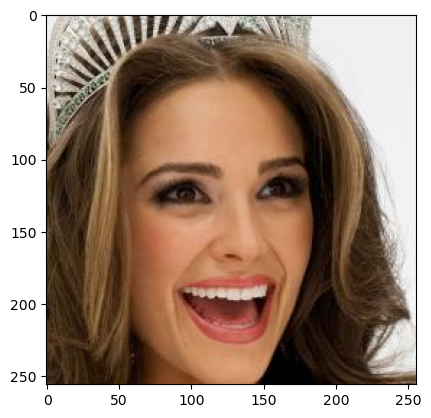

0
255


In [8]:
from matplotlib import pyplot as plt
i = 1
p= Path("/home/yumeng/workspace/Dataset/CelebAHQ/data256x256/",f"{i:05}.jpg").as_posix()
m = plt.imread(p)
print(m.shape)
plt.imshow(m)
plt.show()
print(m.min())
print(m.max())


(128, 128, 3)


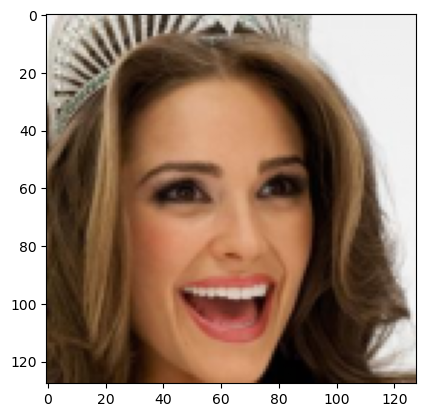

3.139035449114353e-07
0.970408759269769


In [9]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.transform import resize
m2 = resize(m, (128, 128), anti_aliasing=True)
print(m2.shape)
plt.imshow(m2)
plt.show()
print(m2.min())
print(m2.max())

In [10]:
# Before training/load_weights
from pathlib import Path
from matplotlib import pyplot as plt
from skimage.transform import resize
import numpy as np
import cv2
Path(p_results,"forward").mkdir(parents=True,exist_ok=True)
get_path = lambda index:Path(p_results,"forward",f"{index:05}.png").as_posix()
def imwrite_plain(path, figure):
    """归一化到了[-1, 1]的图片矩阵保存为图片
    """
    #cv2.imwrite(path, figure)
    figure = np.clip(figure,0,1)
    plt.imsave(path,figure)

get_path_tr = lambda i: Path("/home/yumeng/workspace/Dataset/CelebAHQ/data256x256/",f"{i:05}.jpg").as_posix()
## 
def forward_verbose(get_path_tr , get_path, n=4, z_samples=None, t0=0):
    """随机采样函数
    """
    if z_samples is None:
        # image grid: n^2 H W 3
        l = []
        for i in range(n*n):
            m = plt.imread(get_path_tr(i+1))
            m2 = resize(m,(128,128), anti_aliasing=True) # become 0-1 image
            l.append(m2)
        z_samples = np.stack(l)
    else:
        z_samples = z_samples.copy()
    
    x_samples = z_samples
    figure = np.zeros((img_size * n, img_size * n, 3))
    for i in range(n):
        for j in range(n):
            digit = x_samples[i * n + j]
            figure[i * img_size:(i + 1) * img_size,
                j * img_size:(j + 1) * img_size] = digit
    imwrite_plain(get_path(0), figure)
        
    for t in tqdm(range(t0, T), ncols=0):
        bt = np.array([[t]] * z_samples.shape[0])
        z_samples *=alpha[t]
        z_samples += np.random.randn(*z_samples.shape) * beta[t]
        
        # output as image grid
        x_samples = z_samples
        
        figure = np.zeros((img_size * n, img_size * n, 3))
        for i in range(n):
            for j in range(n):
                digit = x_samples[i * n + j]
                figure[i * img_size:(i + 1) * img_size,
                    j * img_size:(j + 1) * img_size] = digit
        imwrite_plain(get_path(t+1), figure)


In [11]:
# forward_verbose(get_path= get_path,get_path_tr=get_path_tr,n=4)

100% 1000/1000 [04:01<00:00,  4.14it/s]


In [12]:
model.load_weights(p_weights)

2023-04-21 13:16:33.797049: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcuda.so.1
2023-04-21 13:16:33.829566: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1674] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:5e:00.0
2023-04-21 13:16:33.829610: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
2023-04-21 13:16:33.858746: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcublas.so.12
2023-04-21 13:16:33.860631: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcufft.so.11
2023-04-21 13:16:33.860973: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcurand.so.10
2023-04-21 13:16:33.863941: I tensorflow/stream_executor/platform/d

## Sampling

Formlas for function sample:

$z_T \sim \mathtt{N}(0,1).$

For $t=T,T-1,...,1$:
$$\begin{align}
z_{t-1} = \frac{1}{\alpha_t}(z_{t}-\beta_t^2/\bar{\beta}_t*M(z,t)) + \varepsilon_t,
\end{align}
$$
where $M=\epsilon_\theta(x_t,t)$ is Unet, $\varepsilon_t \sim \mathtt{N}(0,\sigma_t^2I)$;

In [ ]:

## Predict: original version
def sample(path=None, n=4, z_samples=None, t0=0):
    """随机采样函数
    """
    if z_samples is None:
        # image grid: n^2 H W 3
        z_samples = np.random.randn(n**2, img_size, img_size, 3) 
    else:
        z_samples = z_samples.copy()
    for t in tqdm(range(t0, T), ncols=0):
        t = T - t - 1
        bt = np.array([[t]] * z_samples.shape[0])
        z_samples -= beta[t]**2 / bar_beta[t] * model.predict([z_samples, bt])
        z_samples /= alpha[t]
        z_samples += np.random.randn(*z_samples.shape) * sigma[t]
    x_samples = np.clip(z_samples, -1, 1)
    if path is None:
        return x_samples
    figure = np.zeros((img_size * n, img_size * n, 3))
    for i in range(n):
        for j in range(n):
            digit = x_samples[i * n + j]
            figure[i * img_size:(i + 1) * img_size,
                   j * img_size:(j + 1) * img_size] = digit
    imwrite(path, figure)

In [ ]:
# sample(Path(p_results,"sample_0.png").as_posix(),n=1)

  0% 0/1000 [00:00<?, ?it/s]


2023-04-10 18:10:51.543839: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcublas.so.12
2023-04-10 18:10:53.226850: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudnn.so.8
100% 1000/1000 [00:24<00:00, 40.74it/s]


In [13]:
from pathlib import Path
Path(p_results,"sample").mkdir(parents=True,exist_ok=True)
get_path = lambda index:Path(p_results,"sample",f"{index:05}.png").as_posix()
## Predict: original version
def sample_verbose(get_path, n=4, z_samples=None, t0=0):
    """随机采样函数
    """
    if z_samples is None:
        # image grid: n^2 H W 3
        z_samples = np.random.randn(n**2, img_size, img_size, 3) 
    else:
        z_samples = z_samples.copy()
    for t in tqdm(range(t0, T), ncols=0):
        t = T - t - 1
        bt = np.array([[t]] * z_samples.shape[0])
        z_samples -= beta[t]**2 / bar_beta[t] * model.predict([z_samples, bt])
        z_samples /= alpha[t]
        z_samples += np.random.randn(*z_samples.shape) * sigma[t]
        
        # output as image grid
        x_samples = np.clip(z_samples, -1, 1)
        
        figure = np.zeros((img_size * n, img_size * n, 3))
        for i in range(n):
            for j in range(n):
                digit = x_samples[i * n + j]
                figure[i * img_size:(i + 1) * img_size,
                    j * img_size:(j + 1) * img_size] = digit
        imwrite(get_path(t), figure)

In [14]:
# sample_verbose(get_path,n=4)

  0% 0/1000 [00:00<?, ?it/s]


2023-04-21 13:16:50.591190: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcublas.so.12
2023-04-21 13:16:52.147290: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudnn.so.8
100% 1000/1000 [02:32<00:00,  6.55it/s]


**Failed**
sample_sigma0

In [ ]:

## Predict: original version, but sigma ==0

def sample_sigma0(path=None, n=4, z_samples=None, t0=0):
    """随机采样函数
    """
    if z_samples is None:
        # image grid: n^2 H W 3
        z_samples = np.random.randn(n**2, img_size, img_size, 3) 
    else:
        z_samples = z_samples.copy()
    for t in tqdm(range(t0, T), ncols=0):
        t = T - t - 1
        bt = np.array([[t]] * z_samples.shape[0])
        z_samples -= beta[t]**2 / bar_beta[t] * model.predict([z_samples, bt])
        z_samples /= alpha[t]
        # not add N(0,sigma_t I) # z_samples += np.random.randn(*z_samples.shape) * sigma[t]
    x_samples = np.clip(z_samples, -1, 1)
    if path is None:
        return x_samples
    figure = np.zeros((img_size * n, img_size * n, 3))
    for i in range(n):
        for j in range(n):
            digit = x_samples[i * n + j]
            figure[i * img_size:(i + 1) * img_size,
                   j * img_size:(j + 1) * img_size] = digit
    imwrite(path, figure)

In [ ]:
#sample_sigma0(Path(p_results,"sample_sigma0_0.png").as_posix(),n=1)

100% 1000/1000 [00:13<00:00, 73.99it/s]


$$\begin{align}
f(t) &= \frac{1}{\bar{\alpha}_t}\frac{\bar{\alpha}_t}{dt},\\
g^2(t) &= 2 \bar{\alpha}_t \bar{\beta}_t \frac{d}{dt}\left(\frac{\bar{\beta}_t}{\bar{\alpha}_t}\right),\\
\nabla_{x_t} \log p (x_t|x_0) &= - \frac{\varepsilon}{\bar{\beta}_t},~ \varepsilon \sim \mathtt{N}(0,I),\\
\end{align}
$$
where
$$ 
\begin{align}
p(x_t|x_0) &= \mathtt{N}(x_t,\bar{\alpha}_tx_0,\bar{\beta}^2 I)\\
            &= \exp\left\{\frac{-(x_t-\bar{\alpha}_tx_0)^2}{2\bar{\beta}^2}\right\},
\end{align}
$$
i.e., $x_t = \bar{\alpha}_t x_0 + \bar{\beta}_t \bar{\varepsilon}_t$, $\bar{\varepsilon}_t \sim \mathtt{N}(0,I)$.


Let 
$$\begin{align}
s_\theta(x_t,t) := - \frac{\epsilon_\theta(x_t,t)}{\bar{\beta}_t}
\end{align}
$$

What we train is $\epsilon_\theta^\circ (x_t,t)=\frac{\bar{\beta}_t}{\beta_t}\epsilon_\theta(x_t,t).$


Target ODE:
$$\begin{align}
\frac{dx}{ds}& = 2\hat{c} s \left(\frac{\epsilon_\theta(x(s),sT)}{\sqrt{1-\hat{\alpha}^2}}-x\right), \\
s & \in [0,1],\\
x(1) &\sim \mathcal{N}(0,I),
\end{align}
$$
where
$$
\begin{align}
\hat{c} &=\frac{cT}{4}\\
\hat{\alpha}(s) &= e^{-\hat{c}s^2}\ \approx \bar{\alpha}(s)\\
\end{align}
$$
following ($s=t/T$ and $t = T,T-1\cdots,1$)
$$
\begin{align}
\epsilon_\theta(x(s),sT)& =\epsilon_\theta(x_t,t = sT)\\
\bar{\alpha}(s) &= \bar{\alpha}(t)\\
\bar{\alpha}_t &= \prod_{k=1}^t \alpha_t,\\ 
\alpha_t &= \sqrt{1-ct/T},
\end{align}
$$

with constants defined in training
$$\begin{align}
T &= 1000 ,\\
c &=  0.02,\\
\end{align}
$$


Recall that 
- $\hat{\alpha}_t \approx \bar{\alpha}_t$ since $\bar{\alpha}_t \approx 1$.
- we choose $\bar{\alpha}_t$ so that $\bar{\beta}_t:=\sqrt{1-\bar{\alpha}_t^2}\rightarrow 1$, when $t\rightarrow T$, in the forward procedure $x_t := \bar{\alpha}_t x_0 + \bar{\beta}_T\bar{\varepsilon}_t$, $\varepsilon \sim \mathcal{N}(0,I)$. 

In [ ]:
def sample_ode_euler_failed(path=None, n =4, z_samples=None, t0=0):
    """failed

    The succeuss on ,see below
    """
    
    hat_c = c*T/4
    hat_alpha = lambda s: np.exp(-hat_c*s*s)
    
    if z_samples is None:
        # image grid: n^2 H W 3
        z_samples = np.random.randn(n**2, img_size, img_size, 3) 
    else:
        z_samples = z_samples.copy()
    for t in tqdm(range(t0, T), ncols=0):
        t = T - t - 1
        # From time t to t-1, z_samples
        # scalar should extend to batch-vector:
        # bt = np.array([[t]] * z_samples.shape[0])
        bt = np.array([[t]] * z_samples.shape[0])
        s = (t+1)/T
        ds = -1/T
        e = beta[t]/bar_beta[t]* model.predict([z_samples,bt])
        dx = ds*2*hat_c*s*(e/np.sqrt(1-hat_alpha(s)**2) - z_samples)
        
        z_samples = z_samples + dx
        ## ---> z_samples
    x_samples = np.clip(z_samples, -1, 1)
    if path is None:
        return x_samples
    figure = np.zeros((img_size * n, img_size * n, 3))
    for i in range(n):
        for j in range(n):
            digit = x_samples[i * n + j]
            figure[i * img_size:(i + 1) * img_size,
                   j * img_size:(j + 1) * img_size] = digit
    imwrite(path, figure)
#sample_ode_euler_failed(Path(p_results,"sample_ode_euler_failed_0.png").as_posix(),n=1)

Blog4.eq12
$$
\begin{align}
x_{t-1} &= \frac{1}{\alpha_t}\left(x_t-(\hat{\beta}_t-\alpha_t\hat{\beta}_{t-1})\epsilon_\theta(x_t,t)\right)
\end{align}
$$

and $\bar{\beta}_0:=0$.

In [ ]:
def sample_b4e12(path=None, n =4, z_samples=None, t0=0):
    """
    """
    
    
    if z_samples is None:
        # image grid: n^2 H W 3
        z_samples = np.random.randn(n**2, img_size, img_size, 3) 
    else:
        z_samples = z_samples.copy()
    for t in tqdm(range(t0, T), ncols=0):
        t = T - t - 1
        # From time t to t-1, z_samples
        # scalar should extend to batch-vector:
        # bt = np.array([[t]] * z_samples.shape[0])
        bt = np.array([[t]] * z_samples.shape[0])
        s = (t+1)/T
        ds = -1/T
        e = beta[t]/bar_beta[t]* model.predict([z_samples,bt])
        if t>=1:
            z_samples = (z_samples- (bar_beta[t]-alpha[t]*bar_beta[t-1])*e) / alpha[t]
        else:
            z_samples = (z_samples- (bar_beta[t])*e) / alpha[t]
        ## ---> z_samples
    x_samples = np.clip(z_samples, -1, 1)
    if path is None:
        return x_samples
    figure = np.zeros((img_size * n, img_size * n, 3))
    for i in range(n):
        for j in range(n):
            digit = x_samples[i * n + j]
            figure[i * img_size:(i + 1) * img_size,
                   j * img_size:(j + 1) * img_size] = digit
    imwrite(path, figure)

In [ ]:
# sample_b4e12(Path(p_results,"sample_b4e12_0.png").as_posix(),n=1)

100% 1000/1000 [00:14<00:00, 71.21it/s]


In [ ]:
def sample_ddim(path=None, n=4, z_samples=None, stride=1, eta=1):
    """随机采样函数
    注：eta控制方差的相对大小；stride空间跳跃
    """
    # 采样参数
    bar_alpha_ = bar_alpha[::stride]
    bar_alpha_pre_ = np.pad(bar_alpha_[:-1], [1, 0], constant_values=1)
    bar_beta_ = np.sqrt(1 - bar_alpha_**2)
    bar_beta_pre_ = np.sqrt(1 - bar_alpha_pre_**2)
    alpha_ = bar_alpha_ / bar_alpha_pre_
    sigma_ = bar_beta_pre_ / bar_beta_ * np.sqrt(1 - alpha_**2) * eta
    epsilon_ = bar_beta_ - alpha_ * np.sqrt(bar_beta_pre_**2 - sigma_**2)
    T_ = len(bar_alpha_)
    # 采样过程
    if z_samples is None:
        z_samples = np.random.randn(n**2, img_size, img_size, 3)
    else:
        z_samples = z_samples.copy()
    for t in tqdm(range(T_), ncols=0):
        t = T_ - t - 1
        bt = np.array([[t * stride]] * z_samples.shape[0])
        z_samples -= epsilon_[t] * model.predict([z_samples, bt])
        z_samples /= alpha_[t]
        z_samples += np.random.randn(*z_samples.shape) * sigma_[t]
    x_samples = np.clip(z_samples, -1, 1)
    if path is None:
        return x_samples
    figure = np.zeros((img_size * n, img_size * n, 3))
    for i in range(n):
        for j in range(n):
            digit = x_samples[i * n + j]
            figure[i * img_size:(i + 1) * img_size,
                   j * img_size:(j + 1) * img_size] = digit
    imwrite(path, figure)

# sample_ddim(Path(p_results,"sample_ddim_0.png").as_posix(),n=2)
# sample_ddim(Path(p_results,"sample_ddim_sig0_0.png").as_posix(),n=2,eta=0)

100% 1000/1000 [00:37<00:00, 26.33it/s]
100% 1000/1000 [00:39<00:00, 25.55it/s]


It just work!

In [1]:
def sample_ddim_ode(path=None, n=4, z_samples=None):
    """随机采样函数
    注：eta控制方差的相对大小=0；stride空间跳跃==1 (noskip)
    """
    stride=1
    eta=0
    # 采样参数
    bar_alpha_ = bar_alpha
    bar_alpha_pre_ = np.pad(bar_alpha_[:-1], [1, 0], constant_values=1)
    bar_beta_ = np.sqrt(1 - bar_alpha_**2)
    bar_beta_pre_ = np.sqrt(1 - bar_alpha_pre_**2)
    alpha_ = bar_alpha_ / bar_alpha_pre_
    epsilon_ = bar_beta_ - alpha_ * bar_beta_pre_
    T_ = len(bar_alpha_)
    # 采样过程
    if z_samples is None:
        z_samples = np.random.randn(n**2, img_size, img_size, 3)
    else:
        z_samples = z_samples.copy()
    for t in tqdm(range(T_), ncols=0):
        t = T_ - t - 1
        bt = np.array([[t]] * z_samples.shape[0]) 
        z_samples -= epsilon_[t] * model.predict([z_samples, bt])
        z_samples /= alpha_[t]
    x_samples = np.clip(z_samples, -1, 1)
    if path is None:
        return x_samples
    figure = np.zeros((img_size * n, img_size * n, 3))
    for i in range(n):
        for j in range(n):
            digit = x_samples[i * n + j]
            figure[i * img_size:(i + 1) * img_size,
                   j * img_size:(j + 1) * img_size] = digit
    imwrite(path, figure)

# sample_ddim_ode(Path(p_results,"sample_ddim_ode_0.png").as_posix(),n=2)
n =8
imgs = sample_ddim_ode(None,n=n)
p = Path(p_results,"sample_ddim_ode")
p.mkdir(exist_ok=True,parents=True)
for i in range(n*n):
    imwrite(Path(p,f"{i}.png").as_posix(),imgs[i])

NameError: name 'bar_alpha' is not defined

That means, if define the model as $\epsilon^\circ_\theta$ in ddpm code, then in blog 1, $\epsilon_\theta = \frac{\beta_t}{\hat{\beta}_t}\epsilon^\circ_\theta$.

But in blog 4 , $\epsilon_\theta =\epsilon^\circ_\theta$.

`#FIXME #NOTICE? Really???`

In [61]:
def sample_ddim_ode_failed(path=None, n=4, z_samples=None):
    """随机采样函数
    注：eta控制方差的相对大小=0；stride空间跳跃==1 (noskip)

    That meas in blog 1 and blog 4, \epsilon_\theta are diffrent.
    """
    stride=1
    eta=0
    # 采样参数
    bar_alpha_ = bar_alpha # t
    bar_alpha_pre_ = np.pad(bar_alpha_[:-1], [1, 0], constant_values=1) # t-1, \alpha_0=1, \beta_0=0
    bar_beta_ = np.sqrt(1 - bar_alpha_**2)
    bar_beta_pre_ = np.sqrt(1 - bar_alpha_pre_**2)
    alpha_ = bar_alpha_ / bar_alpha_pre_
    epsilon_ = bar_beta_ - alpha_ * bar_beta_pre_
    T_ = len(bar_alpha_)
    # 采样过程
    if z_samples is None:
        z_samples = np.random.randn(n**2, img_size, img_size, 3)
    else:
        z_samples = z_samples.copy()
    for t in tqdm(range(T_), ncols=0):
        t = T_ - t - 1
        bt = np.array([[t]] * z_samples.shape[0]) 
        e = beta[t]/bar_beta[t]*model.predict([z_samples, bt])
        z_samples -= epsilon_[t] * e
        z_samples /= alpha_[t]
    x_samples = np.clip(z_samples, -1, 1)
    if path is None:
        return x_samples
    figure = np.zeros((img_size * n, img_size * n, 3))
    for i in range(n):
        for j in range(n):
            digit = x_samples[i * n + j]
            figure[i * img_size:(i + 1) * img_size,
                   j * img_size:(j + 1) * img_size] = digit
    imwrite(path, figure)

# sample_ddim_ode_failed(Path(p_results,"sample_ddim_ode_euler_0.png").as_posix(),n=2)

100% 1000/1000 [00:26<00:00, 38.15it/s]


With this, we modify the sample_ode_euler

In [ ]:

def sample_ode_euler(path=None, n =4, z_samples=None):
    """
    """
    t0=0
    s = (np.arange(T)+1)/T # s=t/T(wrong, since t=0,1,...) cause all-black x_0
    ds = -1/T
    hat_c = c*T/4
    hat_alpha = lambda s: np.exp(-hat_c*s*s)
    coef = np.sqrt(1-hat_alpha(s)**2)

    def rhs(z,k):
        """
        z' = f(z,t)
        """
        bk = np.array([[k]] * z.shape[0]) # Because in training, use list index, so index-t is time-(t+1). bt is not t, but t-index for DNN(x_index, index).
        e = model.predict([z,bk]) # Here, differnet from sample_ode_euler
        f = 2*hat_c*s[k]*(e/coef[k] - z)
        return f

    def euler_step(z,k):
        # k --> k-1
        r = rhs(z,k)
        dx = ds*r
        return dx

    if z_samples is None:
        # image grid: n^2 H W 3
        z_samples = np.random.randn(n**2, img_size, img_size, 3) 
    else:
        z_samples = z_samples.copy()
    for k in tqdm(range(T-1,t0-1,-1), ncols=0):
        # From time t to t-1, z_samples
        # time t value, stored in k=t-1 index in list.
        # scalar should extend to batch-vector:
        # bt = np.array([[t]] * z_samples.shape[0])

        z_samples = z_samples + euler_step(z_samples,k)
        ## ---> z_samples
    x_samples = np.clip(z_samples, -1, 1)
    if path is None:
        return x_samples
    figure = np.zeros((img_size * n, img_size * n, 3))
    for i in range(n):
        for j in range(n):
            digit = x_samples[i * n + j]
            figure[i * img_size:(i + 1) * img_size,
                   j * img_size:(j + 1) * img_size] = digit
    imwrite(path, figure)
sample_ode_euler(Path(p_results,"sample_ode_euler_0.png").as_posix(),n=4)

In [1]:
from pathlib import Path
Path(p_results,"ode_euler").mkdir(parents=True,exist_ok=True)
get_path = lambda index:Path(p_results,"ode_euler",f"{index:05}.png").as_posix()

def sample_ode_euler_verbose(get_path, n =4, z_samples=None):
    """
    """
    t0=0
    s = (np.arange(T)+1)/T # s=t/T(wrong, since t=0,1,...) cause all-black x_0
    ds = -1/T
    hat_c = c*T/4
    hat_alpha = lambda s: np.exp(-hat_c*s*s)
    coef = np.sqrt(1-hat_alpha(s)**2)

    def rhs(z,k):
        """
        z' = f(z,t)
        """
        bk = np.array([[k]] * z.shape[0]) # Because in training, use list index, so index-t is time-(t+1). bt is not t, but t-index for DNN(x_index, index).
        e = model.predict([z,bk]) # Here, differnet from sample_ode_euler
        f = 2*hat_c*s[k]*(e/coef[k] - z)
        return f

    def euler_step(z,k):
        # k --> k-1
        r = rhs(z,k)
        dx = ds*r
        return dx

    if z_samples is None:
        # image grid: n^2 H W 3
        z_samples = np.random.randn(n**2, img_size, img_size, 3) 
    else:
        z_samples = z_samples.copy()
    for k in tqdm(range(T-1,t0-1,-1), ncols=0):
        # From time t to t-1, z_samples
        # time t value, stored in k=t-1 index in list.
        # scalar should extend to batch-vector:
        # bt = np.array([[t]] * z_samples.shape[0])

        z_samples = z_samples + euler_step(z_samples,k)
        ## ---> z_samples
        x_samples = np.clip(z_samples, -1, 1)
        figure = np.zeros((img_size * n, img_size * n, 3))
        for i in range(n):
            for j in range(n):
                digit = x_samples[i * n + j]
                figure[i * img_size:(i + 1) * img_size,
                    j * img_size:(j + 1) * img_size] = digit
        imwrite(get_path(t), figure)

sample_ode_euler_verbose(get_path,n=4)

NameError: name 'p_results' is not defined

In [86]:
def sample_ode_center(path=None, n =4, z_samples=None):
    """
    """
    t0=0
    s = (np.arange(T)+1)/T # s=t/T(wrong, since t=0,1,...) cause all-black x_0
    ds = -1/T
    hat_c = c*T/4
    hat_alpha = lambda s: np.exp(-hat_c*s*s)
    coef = np.sqrt(1-hat_alpha(s)**2)

    def rhs(z,k):
        """
        z' = f(z,t)
        """
        bk = np.array([[k]] * z.shape[0]) # Because in training, use list index, so index-t is time-(t+1). bt is not t, but t-index for DNN(x_index, index).
        e = model.predict([z,bk]) # Here, differnet from sample_ode_euler
        f = 2*hat_c*s[k]*(e/coef[k] - z)
        return f

    def euler_step(z,k):
        # k --> k-1
        r = rhs(z,k)
        dx = ds*r
        return dx

    if z_samples is None:
        # image grid: n^2 H W 3
        z_samples = np.random.randn(n**2, img_size, img_size, 3) 
    else:
        z_samples = z_samples.copy()
    
    z_nex = z_samples # k+1
    z = z_nex + euler_step(z_samples,T-1) # k
    for k in tqdm(range(T-2,t0-1,-1), ncols=0):
        # k+1,k --> k-1
        dx = 2*ds*rhs(z,k)
        z,z_nex = z_nex + dx,z
        
        ## ---> z_samples
    x_samples = np.clip(z, -1, 1)
    if path is None:
        return x_samples
    figure = np.zeros((img_size * n, img_size * n, 3))
    for i in range(n):
        for j in range(n):
            digit = x_samples[i * n + j]
            figure[i * img_size:(i + 1) * img_size,
                   j * img_size:(j + 1) * img_size] = digit
    imwrite(path, figure)
sample_ode_center(Path(p_results,"sample_ode_center_0.png").as_posix(),n=4)

100% 999/999 [01:25<00:00, 11.72it/s]


Adams-Bashforth method

https://en.wikiversity.org/wiki/Adams-Bashforth_and_Adams-Moulton_methods

$$
y_{n+1}=y_{n}+{\frac{3}{2}}hf(t_{n},y_{n})-{\frac {1}{2}}hf(t_{n-1},y_{n-1})
$$

In [93]:
def sample_ode_AB(path=None, n =4, z_samples=None):
    """Adams-Bashforth
    """
    t0=0
    s = (np.arange(T)+1)/T # s=t/T(wrong, since t=0,1,...) cause all-black x_0
    ds = -1/T
    hat_c = c*T/4
    hat_alpha = lambda s: np.exp(-hat_c*s*s)
    coef = np.sqrt(1-hat_alpha(s)**2)

    def rhs(z,k):
        """
        z' = f(z,t)
        """
        bk = np.array([[k]] * z.shape[0]) # Because in training, use list index, so index-t is time-(t+1). bt is not t, but t-index for DNN(x_index, index).
        e = model.predict([z,bk]) # Here, differnet from sample_ode_euler
        f = 2*hat_c*s[k]*(e/coef[k] - z)
        return f

    def euler_step(z,k):
        # k --> k-1
        r = rhs(z,k)
        dx = ds*r
        return dx
    

    if z_samples is None:
        # image grid: n^2 H W 3
        z_samples = np.random.randn(n**2, img_size, img_size, 3) 
    else:
        z_samples = z_samples.copy()
    
    z_nex = z_samples # k+1
    z = z_nex + euler_step(z_samples,T-1) # k
    for k in tqdm(range(T-2,t0-1,-1), ncols=0):
        # k+1,k --> k-1
        dx = 1.5*ds*rhs(z,k) -0.5*ds*rhs(z_nex,k+1)
        z,z_nex = z + dx,z
        
        ## ---> z_samples
    x_samples = np.clip(z, -1, 1)
    if path is None:
        return x_samples
    figure = np.zeros((img_size * n, img_size * n, 3))
    for i in range(n):
        for j in range(n):
            digit = x_samples[i * n + j]
            figure[i * img_size:(i + 1) * img_size,
                   j * img_size:(j + 1) * img_size] = digit
    imwrite(path, figure)
sample_ode_AB(Path(p_results,"sample_ode_AB_0.png").as_posix(),n=4)

100% 999/999 [00:54<00:00, 18.31it/s]


The Runge–Kutta method

https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods

Now we pick a step-size h > 0 and define:

$$
 \begin{aligned}
    y_{n+1}&=y_{n}+{\frac {1}{6}}\left(k_{1}+2k_{2}+2k_{3}+k_{4}\right)h,\\
    t_{n+1}&=t_{n}+h\\
    \end{aligned}
$$

for n = 0, 1, 2, 3, ..., using

$$
\begin{aligned}
k_{1}&=\ f(t_{n},y_{n}),\\
k_{2}&=\ f\left(t_{n}+{\frac {h}{2}},y_{n}+h{\frac {k_{1}}{2}}\right),\\
k_{3}&=\ f\left(t_{n}+{\frac {h}{2}},y_{n}+h{\frac {k_{2}}{2}}\right),\\
k_{4}&=\ f\left(t_{n}+h,y_{n}+hk_{3}\right).
\end{aligned}
$$

$k_{1}$ is the slope at the beginning of the interval, using $y$ (Euler's method);

$k_{2}$ is the slope at the midpoint of the interval, using $y$ and $k_{1}$;

$k_{3}$ is again the slope at the midpoint, but now using $y$ and $k_{2}$;

$k_{4}$ is the slope at the end of the interval, using $y$ and $k_{3}$.

In [94]:
def sample_ode_RK(path=None, n =4, z_samples=None):
    """Runge-kutta, RK4
    """
    t0=0
    s = (np.arange(T)+1)/T # s=t/T(wrong, since t=0,1,...) cause all-black x_0
    ds = -1/T
    hat_c = c*T/4
    hat_alpha = lambda s: np.exp(-hat_c*s*s)
    coef = np.sqrt(1-hat_alpha(s)**2)

    def rhs_(z,k):
        """
        k is not integer now.
        z' = f(z,t)
        """
        bk = np.array([[k]] * z.shape[0]) # Because in training, use list index, so index-t is time-(t+1). bt is not t, but t-index for DNN(x_index, index).
        e = model.predict([z,bk]) # Here, differnet from sample_ode_euler
        s_ = (k+1)/T
        coef_ = np.sqrt(1-hat_alpha(s_)**2)
        f = 2*hat_c*s_*(e/coef_ - z)
        return f

    if z_samples is None:
        # image grid: n^2 H W 3
        z_samples = np.random.randn(n**2, img_size, img_size, 3) 
    else:
        z_samples = z_samples.copy()
    
    z = z_samples
    for k in tqdm(range(T-1,t0-1,-1), ncols=0):
        # k --> k-1
        r1 = rhs_(z,k)
        r2 = rhs_(z+ds*r1/2,k+ds/2)
        r3 = rhs_(z+ds*r2/2,k+ds/2)
        r4 = rhs_(z+ds*r3,k+ds)

        dx = 1/6*(r1+2*r2+2*r3+r4)*ds
        z = z+dx
        
        ## ---> z_samples
    x_samples = np.clip(z, -1, 1)
    if path is None:
        return x_samples
    figure = np.zeros((img_size * n, img_size * n, 3))
    for i in range(n):
        for j in range(n):
            digit = x_samples[i * n + j]
            figure[i * img_size:(i + 1) * img_size,
                   j * img_size:(j + 1) * img_size] = digit
    imwrite(path, figure)
sample_ode_RK(Path(p_results,"sample_ode_RK_0.png").as_posix(),n=4)

100% 1000/1000 [05:45<00:00,  2.89it/s]
